In [1]:
import pandas as pd
import numpy as nppip
import yaml
import os
import matplotlib.pyplot as plt

In [217]:
def read_yaml_files_to_dataframe(directory):
    rows_list = []
    for filename in sorted(os.listdir(directory)):
        if filename.endswith(".yaml"):
            file_path = os.path.join(directory, filename)
            file_number = filename.split('.')[0]

            with open(file_path, 'r') as file:
                content = yaml.safe_load(file)

                instance_data = content['problem']['instance']
                bottom_name = content['problem']['shape']['name']

                if 'matmul' in bottom_name:
                    layer_type = 'matmul'
                    group_name = None
                    resid_block_num = None
                    mamba_block = None
                elif len(bottom_name.split('_')) < 3:
                    group_name = bottom_name.split('_')[0]
                    layer_type = bottom_name.split('_')[1]
                    resid_block_num = None
                    mamba_block = None
                else:
                    group_name = bottom_name.split('_')[0]
                    resid_block_num = int(bottom_name.split('_')[1])
                    mamba_block = bottom_name.split('_')[2]
                    if len(bottom_name.split('_')) == 4:
                        layer_type = bottom_name.split('_')[3]
                    else:
                        layer_type = bottom_name.split('_')[3] + '_' + bottom_name.split('_')[4]

                row_data = {'File Number': file_number, 'Name': bottom_name, 'Group': group_name, 'Residual Block Number': resid_block_num, 'Mamba Block': mamba_block, 'Layer Type': layer_type}
                row_data.update(instance_data)
                rows_list.append(row_data)

    df = pd.DataFrame(rows_list)
    return df


def parse_stats(file_path):
    # Define the keys we want to extract from the stats section
    keys = [
        "GFLOPs (@1GHz)", "Utilization", "Cycles", "Energy", "EDP(J*cycle)", "Area",
        "mac", "psum_spad", "weights_spad", "ifmap_spad", "shared_glb", "DRAM", "Total"
    ]
    values = {}
    
    # Start reading file when "Summary Stats" is found
    with open(file_path, 'r') as file:
        record = False
        record_compute = False
        for line in file:
            if "Summary Stats" in line:
                record = True
            if "fJ/Compute" in line:
                record_compute = True
            if record:
                if ":" in line:
                    key, value = line.split(':')
                    key = key.strip()
                    value = value.strip().split()[0]  # Split to ignore units and take the first value
                    if key in keys:
                        values[key] = value
                if "Total" in line and line.startswith("    Total"):
                    record = False
            if record_compute:
                if "=" in line:  # Look for lines with '=' which denotes key-value pairs in fJ/Compute section
                    key, value = line.strip().split('=')
                    key = key.strip()
                    value = value.strip().split()[0]  # Strip and split to ignore spaces and units
                    values[key] = value
                if "Total" in line and line.startswith("    Total"):  # Stop recording after Total
                    break
    return values

def read_stats_from_directories(base_directory):
    rows_list = []

    # Iterate over subdirectories
    for subdir in sorted(os.listdir(base_directory)):
        dir_path = os.path.join(base_directory, subdir)
        if os.path.isdir(dir_path):
            stats_file = os.path.join(dir_path, 'timeloop-mapper.stats.txt')
            if os.path.exists(stats_file):
                # Parse the stats file
                stats = parse_stats(stats_file)
                # Add the file number (subdirectory name) to the row
                stats['Layer Number'] = subdir
                rows_list.append(stats)

    # Create DataFrame from list of rows
    df = pd.DataFrame(rows_list)
    return df

def create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER):
    merged_df = pd.merge(read_stats_from_directories(OUTPUT_DIRECTORY), read_yaml_files_to_dataframe(BASE_FOLDER), left_on='Layer Number', right_on='File Number', how='inner')
    merged_df = merged_df.drop(columns=['File Number'])
    return merged_df

def convert_to_floats(merged_df):
    #try converting every column to floats
    for column in merged_df.columns:
        try:
            merged_df[column] = merged_df[column].astype(float)
        except:
            print('failed to convert column to float', column)
            pass

    merged_df['Utilization'] = merged_df['Utilization'].str.rstrip('%').astype('float')
    merged_df.rename(columns={'Utilization': 'Utilization (%)'}, inplace=True)

    return merged_df

def plot_breakdown_per_cycle(block_df, skip_4 = False, layer_name = 'Layer Number', model_name = None):
    if skip_4:
        one_block = block_df[block_df['Layer Number'] != 4]
    else:
        one_block = block_df.copy()
    plt.figure()
    plt.bar(one_block[layer_name], one_block['DRAM'], label = 'DRAM', color = 'blue')
    plt.bar(one_block[layer_name], one_block['shared_glb'], label = 'shared_glb', color = 'orange', bottom = one_block['DRAM'])
    plt.bar(one_block[layer_name], one_block['ifmap_spad'], label = 'ifmap_spad', color = 'green', bottom = one_block['DRAM'] + one_block['shared_glb'])
    plt.bar(one_block[layer_name], one_block['weights_spad'], label = 'weights_spad', color = 'red', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'])
    plt.bar(one_block[layer_name], one_block['psum_spad'], label = 'psum_spad', color = 'purple', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'] + one_block['weights_spad'])
    plt.bar(one_block[layer_name], one_block['mac'], label = 'mac', color = 'brown', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'] + one_block['weights_spad'] + one_block['psum_spad'])
    plt.legend()
    plt.xlabel(layer_name)
    plt.ylabel('Energy Used (fJ / Cycle)')
    plt.title(f'Energy Breakdown by Layer for {model_name}')
    plt.show()


def cycles_and_energy_plot(one_block, model_name = None):
    plt.figure()
    fig, ax1 = plt.subplots()
    ax2 = ax1.twinx()
    ax1.bar(one_block['Layer Number'], one_block['Energy'], label='Energy', color='blue')
    ax2.scatter(one_block['Layer Number'], one_block['Cycles'] / 1e6, label='Cycles', color='orange')
    ax1.set_xlabel('Layer Number')
    ax1.set_ylabel('Total Energy (uJ)', color='blue')
    ax2.set_ylabel('Total Cycles (in millions)', color='orange')
    plt.title(f'Total Energy and Cycles per Layer Type for {model_name}')
    plt.show()

In [218]:
NETWORK_NAME = 'gpt2'
BASE_FOLDER = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/{NETWORK_NAME}'
OUTPUT_DIRECTORY = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/{NETWORK_NAME}'

In [219]:
gpt2_df = read_stats_from_directories(OUTPUT_DIRECTORY)
gpt2_df = convert_to_floats(gpt2_df)
gpt2_block = gpt2_df[gpt2_df['Layer Number'] <= 5]

failed to convert column to float Utilization


In [220]:
NETWORK_NAME = 'mamba_370m'
BASE_FOLDER = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/{NETWORK_NAME}'
OUTPUT_DIRECTORY = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/{NETWORK_NAME}'

In [221]:
mamba_df = create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER)
mamba_df = convert_to_floats(mamba_df)
mamba_df.loc[mamba_df['Layer Type'] == 'matmul', ['Energy', 'Cycles']] *= 256
mamba_block = mamba_df[mamba_df['Layer Number'] <= 5]

failed to convert column to float Utilization
failed to convert column to float Name
failed to convert column to float Group
failed to convert column to float Mamba Block
failed to convert column to float Layer Type


In [222]:
NETWORK_NAME = 'mamba_1.4b'

BASE_FOLDER = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/{NETWORK_NAME}'
OUTPUT_DIRECTORY = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/{NETWORK_NAME}'

In [223]:
mamba_big_df = create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER)
mamba_big_df = convert_to_floats(mamba_big_df)
mamba_big_df.loc[mamba_big_df['Layer Type'] == 'matmul', ['Energy', 'Cycles']] *= 256
mamba_big_block = mamba_big_df[mamba_big_df['Layer Number'] <= 5]


failed to convert column to float Utilization
failed to convert column to float Name
failed to convert column to float Group
failed to convert column to float Mamba Block
failed to convert column to float Layer Type


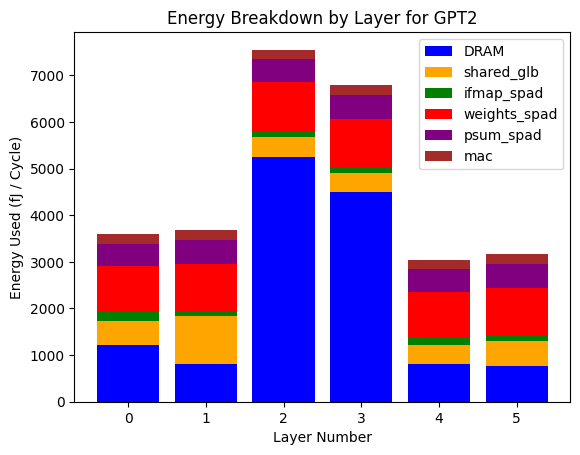

In [224]:
plot_breakdown_per_cycle(gpt2_block, model_name = 'GPT2')

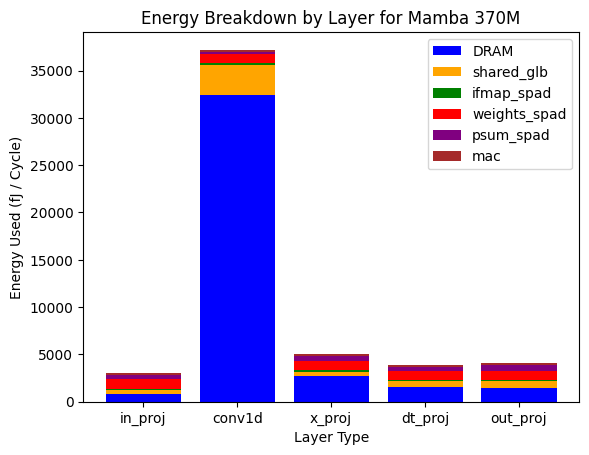

In [225]:
plot_breakdown_per_cycle(mamba_block, skip_4 = True, layer_name = 'Layer Type', model_name = 'Mamba 370M')

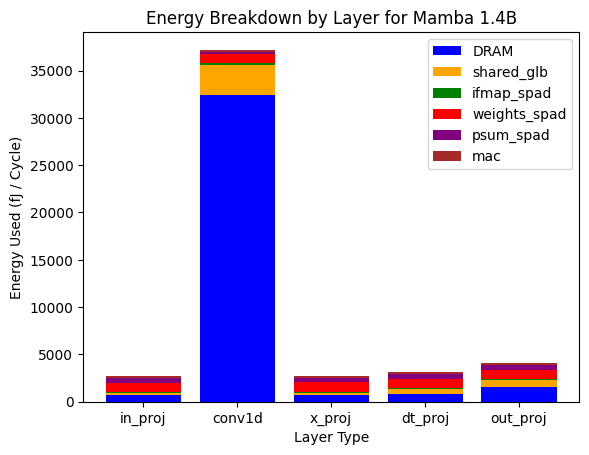

In [226]:
plot_breakdown_per_cycle(mamba_big_block, skip_4 = True, layer_name = 'Layer Type', model_name = 'Mamba 1.4B')

<Figure size 640x480 with 0 Axes>

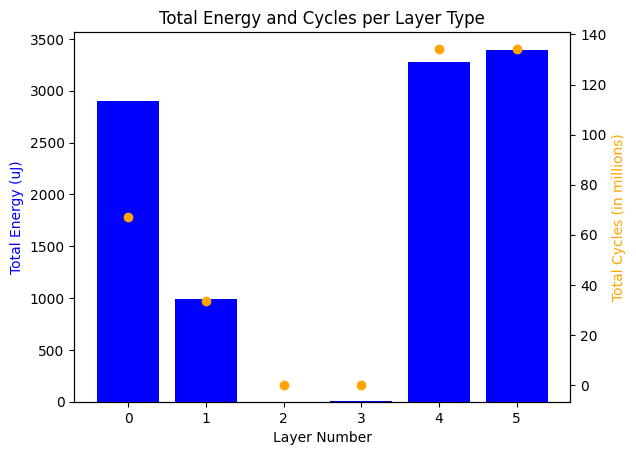

In [211]:
cycles_and_energy_plot(gpt2_block)

<Figure size 640x480 with 0 Axes>

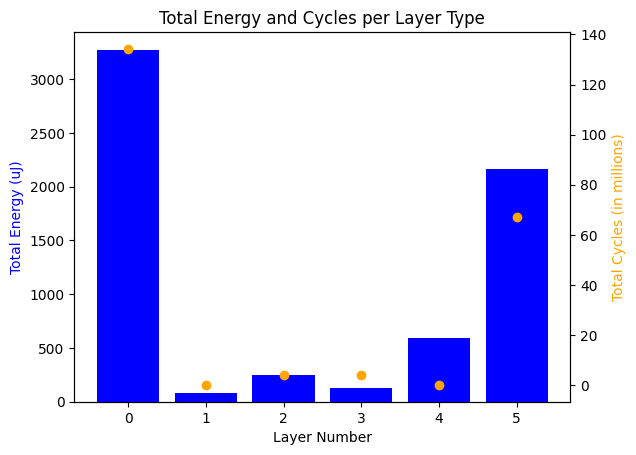

In [212]:
cycles_and_energy_plot(mamba_block)

<Figure size 640x480 with 0 Axes>

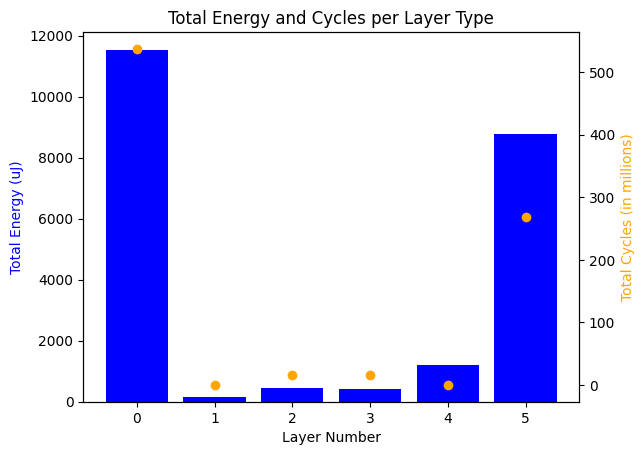

In [213]:
cycles_and_energy_plot(mamba_big_block)

In [104]:
gpt_block_sum = pd.concat([gpt2_block['Layer Number'].astype(int) + 1, gpt2_block['Energy']], axis=1)
gpt_block_sum.set_index('Layer Number', inplace=True)
gpt_block_sum.loc['Total Energy (uJ)'] = gpt_block_sum.sum()

In [196]:
mamba_block['Layer Number']

0    0.0
1    1.0
2    2.0
3    3.0
4    4.0
5    5.0
Name: Layer Number, dtype: float64

In [165]:
gpt2_block

,GFLOPs (@1GHz),Utilization (%),Cycles,Energy,EDP(J*cycle),Area,mac,psum_spad,weights_spad,ifmap_spad,shared_glb,DRAM,Total,Layer Number
0,23.99,7.14,67108864.0,2897.96,194000.0000,0.0,207.69,483.31,993.57,189.68,515.99,1208.33,3598.57,0.0
1,15.99,4.76,33554432.0,988.47,33200.0000,0.0,207.69,524.85,997.24,106.84,1033.20,812.50,3682.33,1.0
2,15.97,4.76,32768.0,1.98,0.0649,0.0,207.69,490.57,1048.69,123.41,429.82,5250.00,7550.19,2.0
3,15.97,4.76,131072.0,7.12,0.9330,0.0,207.69,510.61,1048.69,112.37,409.11,4500.00,6788.47,3.0
4,15.99,4.76,134217728.0,3274.80,440000.0000,0.0,207.69,483.77,993.57,145.50,406.87,812.50,3049.90,4.0
5,16.00,4.76,134217728.0,3395.72,456000.0000,0.0,207.69,524.85,997.24,123.41,543.69,765.62,3162.51,5.0


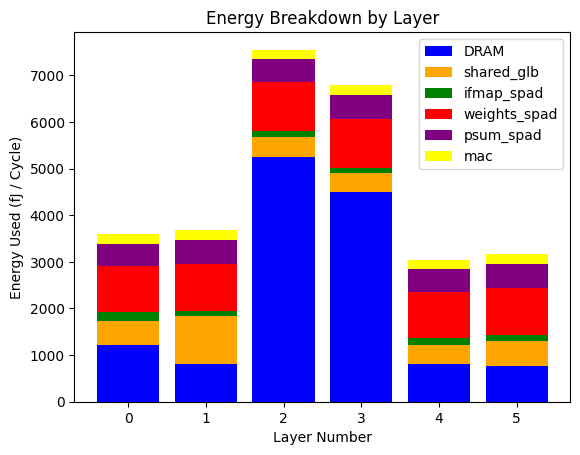

In [168]:
one_block = gpt2_block.copy()
plt.figure()
plt.bar(one_block['Layer Number'], one_block['DRAM'], label = 'DRAM', color = 'blue')
plt.bar(one_block['Layer Number'], one_block['shared_glb'], label = 'shared_glb', color = 'orange', bottom = one_block['DRAM'])
plt.bar(one_block['Layer Number'], one_block['ifmap_spad'], label = 'ifmap_spad', color = 'green', bottom = one_block['DRAM'] + one_block['shared_glb'])
plt.bar(one_block['Layer Number'], one_block['weights_spad'], label = 'weights_spad', color = 'red', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'])
plt.bar(one_block['Layer Number'], one_block['psum_spad'], label = 'psum_spad', color = 'purple', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'] + one_block['weights_spad'])
plt.bar(one_block['Layer Number'], one_block['mac'], label = 'mac', color = 'yellow', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'] + one_block['weights_spad'] + one_block['psum_spad'])
plt.legend()
plt.xlabel('Layer Number')
plt.ylabel('Energy Used (fJ / Cycle)')
plt.title('Energy Breakdown by Layer')
plt.show()

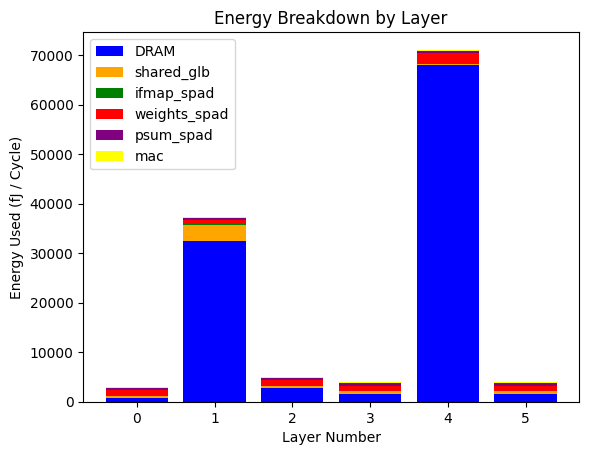

In [169]:
one_block = mamba_block.copy()
plt.figure()
plt.bar(one_block['Layer Number'], one_block['DRAM'], label = 'DRAM', color = 'blue')
plt.bar(one_block['Layer Number'], one_block['shared_glb'], label = 'shared_glb', color = 'orange', bottom = one_block['DRAM'])
plt.bar(one_block['Layer Number'], one_block['ifmap_spad'], label = 'ifmap_spad', color = 'green', bottom = one_block['DRAM'] + one_block['shared_glb'])
plt.bar(one_block['Layer Number'], one_block['weights_spad'], label = 'weights_spad', color = 'red', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'])
plt.bar(one_block['Layer Number'], one_block['psum_spad'], label = 'psum_spad', color = 'purple', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'] + one_block['weights_spad'])
plt.bar(one_block['Layer Number'], one_block['mac'], label = 'mac', color = 'yellow', bottom = one_block['DRAM'] + one_block['shared_glb'] + one_block['ifmap_spad'] + one_block['weights_spad'] + one_block['psum_spad'])
plt.legend()
plt.xlabel('Layer Number')
plt.ylabel('Energy Used (fJ / Cycle)')
plt.title('Energy Breakdown by Layer')
plt.show()

failed to convert column to float Utilization
failed to convert column to float Name
failed to convert column to float Group
failed to convert column to float Mamba Block
failed to convert column to float Layer Type


In [148]:
mamba_block_sum = pd.concat([mamba_block['Layer Number'].astype(int) + 1, mamba_block['Energy']], axis=1)
mamba_block_sum.set_index('Layer Number', inplace=True)
mamba_block_sum.loc['Total Energy (uJ)'] = mamba_block_sum.sum()

In [149]:
block_energy = pd.concat([mamba_block_sum['Energy'], gpt_block_sum['Energy']], axis=1)
block_energy.columns = ['Mamba 370M', 'GPT2']

In [153]:
mamba_df['Energy'].sum()

355216.86999999994

In [150]:
block_energy


,Mamba 370M,GPT2
Layer Number,,
1,3274.80,2897.96
2,78.06,988.47
3,253.05,1.98
4,130.73,7.12
5,596.48,3274.80
6,2164.53,3395.72
Total Energy (uJ),6497.65,10566.05


In [155]:
NETWORK_NAME = 'mamba_1.4b'

BASE_FOLDER = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/layer_shapes/{NETWORK_NAME}'
OUTPUT_DIRECTORY = f'/Users/andis/Documents/MIT/hardware_arch/6.5931-final-project/workspace/final-project/example_designs/example_designs/eyeriss_like/outputs/{NETWORK_NAME}'

In [160]:
mamba_big_df = create_merged_df(OUTPUT_DIRECTORY, BASE_FOLDER)

mamba_big_df = convert_to_floats(mamba_big_df)

mamba_big_df.loc[mamba_big_df['Layer Type'] == 'matmul', ['Energy', 'Cycles']] *= 256

mamba_big_block = mamba_big_df[mamba_big_df['Layer Number'] <= 5]



failed to convert column to float Utilization
failed to convert column to float Name
failed to convert column to float Group
failed to convert column to float Mamba Block
failed to convert column to float Layer Type


In [161]:
mamba_big_block_sum = pd.concat([mamba_big_block['Layer Type'], mamba_big_block['Energy']], axis=1)
mamba_big_block_sum.set_index('Layer Type', inplace=True)
mamba_big_block_sum.loc['Total Energy (uJ)'] = mamba_big_block_sum.sum()

mamba_block_sum = pd.concat([mamba_block['Layer Type'], mamba_block['Energy']], axis=1)
mamba_block_sum.set_index('Layer Type', inplace=True)
mamba_block_sum.loc['Total Energy (uJ)'] = mamba_block_sum.sum()

In [162]:
mamba_energy = pd.concat([mamba_block_sum['Energy'], mamba_big_block_sum['Energy']], axis=1)
mamba_energy.columns = ['Mamba 370M', 'Mamba 1.4B']

In [163]:
mamba_energy['Multiplier'] = mamba_energy['Mamba 1.4B'] / mamba_energy['Mamba 370M']
mamba_energy.round(2)

,Mamba 370M,Mamba 1.4B,Multiplier
Layer Type,,,
in_proj,3274.80,11537.50,3.52
conv1d,78.06,156.08,2.00
x_proj,253.05,457.22,1.81
dt_proj,130.73,418.88,3.20
matmul,596.48,1190.40,2.00
out_proj,2164.53,8774.16,4.05
Total Energy (uJ),6497.65,22534.24,3.47


In [134]:
mamba_df['Energy'].sum()
mamba_big_df['Energy'].sum()

320383.91000000003

In [136]:
gpt2_df['Energy'].sum()

337190.42999999993

In [141]:
gpt2_df

,GFLOPs (@1GHz),Utilization (%),Cycles,Energy,EDP(J*cycle),Area,mac,psum_spad,weights_spad,ifmap_spad,shared_glb,DRAM,Total,Layer Number
0,23.99,7.14,6.710886e+07,2897.96,1.940000e+05,0.0,207.69,483.31,993.57,189.68,515.99,1208.33,3598.57,0.0
1,15.99,4.76,3.355443e+07,988.47,3.320000e+04,0.0,207.69,524.85,997.24,106.84,1033.20,812.50,3682.33,1.0
2,15.97,4.76,3.276800e+04,1.98,6.490000e-02,0.0,207.69,490.57,1048.69,123.41,429.82,5250.00,7550.19,2.0
3,15.97,4.76,1.310720e+05,7.12,9.330000e-01,0.0,207.69,510.61,1048.69,112.37,409.11,4500.00,6788.47,3.0
4,15.99,4.76,1.342177e+08,3274.80,4.400000e+05,0.0,207.69,483.77,993.57,145.50,406.87,812.50,3049.90,4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,15.97,4.76,3.276800e+04,1.98,6.490000e-02,0.0,207.69,490.57,1048.69,123.41,429.82,5250.00,7550.19,140.0
141,15.97,4.76,1.310720e+05,7.12,9.330000e-01,0.0,207.69,510.61,1048.69,112.37,409.11,4500.00,6788.47,141.0
142,15.99,4.76,1.342177e+08,3274.80,4.400000e+05,0.0,207.69,483.77,993.57,145.50,406.87,812.50,3049.90,142.0
143,16.00,4.76,1.342177e+08,3395.72,4.560000e+05,0.0,207.69,524.85,997.24,123.41,543.69,765.62,3162.51,143.0
